In [1]:
import os
import xarray as xr
import datetime as dt
import erddapy
from erddapy import ERDDAP
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
import seawater as sw
import cmocean.cm as cmo
from scipy.interpolate import interp1d
import pandas as pd
from datetime import datetime
from datetime import timedelta
import datetime as dt

myFmt = mdates.DateFormatter('%m/%d')
myFmtlong = mdates.DateFormatter('%m/%d\n%H:%M')

## Set plotting parameters
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

# increase text sizes because the figure is so big
fac =1.5
plt.rc('font', size=SMALL_SIZE * fac)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE * fac)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE * fac)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE * fac)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE * fac)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE * fac)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE * fac *0.8)  # fontsize of the figure title

peakWindTime = '2021-08-29T08:00:00'
landfallTime = '2021-08-29T17:00:00'

tstart = "2021-8-25 00:00:00" # Start from near our initial condition time
tend   = "2021-9-04 00:00:00" # Run until after the eye passed
tstart_dt = dt.datetime(2021, 8, 25, 0, 0)
tend_dt = dt.datetime(2021, 9, 4, 0, 0)

In [2]:
# grab an individual gliders data
ioos_url = 'https://data.ioos.us/gliders/erddap'
def get_erddap_dataset(ds_id, variables=None, constraints=None, filetype=None):
    """
    Returns a netcdf dataset for a specified dataset ID (or dataframe if dataset cannot be converted to xarray)
    :param ds_id: dataset ID e.g. ng314-20200806T2040
    :param variables: optional list of variables
    :param constraints: optional list of constraints
    :param filetype: optional filetype to return, 'nc' (default) or 'dataframe'
    :return: netcdf dataset
    """
    variables = variables or None
    constraints = constraints or None
    filetype = filetype or 'nc'

    e = ERDDAP(server=ioos_url,
               protocol='tabledap',
               response='nc')
    e.dataset_id = ds_id
    if constraints:
        e.constraints = constraints
    if variables:
        e.variables = variables
    if filetype == 'nc':
        try:
            ds = e.to_xarray()
            ds = ds.sortby(ds.time)
        except OSError:
            print('No dataset available for specified constraints: {}'.format(ds_id))
            ds = []
        except TypeError:
            print('Cannot convert to xarray, providing dataframe: {}'.format(ds_id))
            ds = e.to_pandas().dropna()
    elif filetype == 'dataframe':
        ds = e.to_pandas().dropna()
    else:
        print('Unrecognized filetype: {}. Needs to  be "nc" or "dataframe"'.format(filetype))

    return ds

def glider_dataset(gliderid, time_start=None, time_end=None, variables=None, filetype=None):
    """
    Return data from a specific glider
    """
    print('Retrieving glider dataset: {}'.format(gliderid))
    time_start = time_start or None
    time_end = time_end or None
    variables = variables or [
        'depth',
        'latitude',
        'longitude',
        'time',
        'temperature',
        'salinity',
        'density',
        'profile_id'
    ]
    filetype = filetype or 'nc'

    constraints = dict()
    if time_start:
        constraints['time>='] = time_start.strftime('%Y-%m-%dT%H:%M:%SZ')
    if time_end:
        constraints['time<='] = time_end.strftime('%Y-%m-%dT%H:%M:%SZ')

    if len(constraints) < 1:
        constraints = None

    kwargs = dict()
    kwargs['variables'] = variables
    kwargs['constraints'] = constraints
    kwargs['filetype'] = filetype

    ds = get_erddap_dataset(gliderid, **kwargs)
    if isinstance(ds, pd.core.frame.DataFrame):
        for col in ds.columns:
            ds.rename(columns={col: col.split(' ')[0]}, inplace=True)  # get rid of units in column names
        ds['time'] = ds['time'].apply(lambda t: dt.datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ'))

    return ds

def depth_interpolate(df, depth_var='depth', depth_min=0, depth_max=None, stride=1, method='linear'):
    """

    :param df: depth profile in the form of a pandas dataframe
    :param depth_var: the name of the depth variable in the dataframe
    :param depth_min: the shallowest bin depth
    :param depth_max: the deepest bin depth
    :param stride: the amount of space between each bin
    :param method: interpolation type: defaults to linear.https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
    :return: pandas dataframe where data has been interpolated to specific depths
    """
    depth_max = depth_max or df[depth_var].max()

    bins = np.arange(depth_min, depth_max+stride, stride)

    # Create temporary dataframe to interpolate to dz m depths
    temp = df.set_index(depth_var) #set index to depth
    temp = temp[~temp.index.duplicated()] #Remove duplicated indexs (not sure why there would be duplicates)
    temp = temp.reindex(temp.index.union(bins)) # reindex to depths in bins
    temp = temp.drop('time', axis=1).interpolate(method=method, limit_direction='both')  # drop time and interpolate new depth indexes
    temp = temp.reindex(index=bins)  # only want to see new_index data
    temp = temp.reset_index()  # reset index so you can access the depth variable

    return temp

In [3]:
## load and grid the glider data by profile and depth
glider = 'ng645-20210613T0000'
save_dir = '/Users/coakley/Github/Ida/data/'
t0 = tstart_dt
t1 =  tend_dt

# initialize keyword arguments for glider functions
gargs = dict()
gargs['time_start'] = t0  # False
gargs['time_end'] =t1
gargs['filetype'] = 'dataframe'

sdir_glider = os.path.join(save_dir, glider, 'transects', 'transect-ribbons')
os.makedirs(sdir_glider, exist_ok=True)
glider_df = glider_dataset(glider, **gargs)

profs = np.unique(glider_df['profile_id'])
prof_time = []
temp = np.empty((101,len(profs)))
temp[:] = np.nan
sal = np.empty((101,len(profs)))
sal[:] = np.nan
dens = np.empty((101,len(profs)))
dens[:] = np.nan

zmax = 101
depths = np.arange(0,zmax,1)
count=0

# Get grids of TSD 
for profile in profs:
    _tmpdf = glider_df[glider_df['profile_id']==profile] # pull out one profile
    prof_time.append(_tmpdf['time'].values[0]) # store the time of each profile
    
    _interpdf = depth_interpolate(_tmpdf, depth_var='depth', depth_min=0, depth_max=None, stride=1) # interpolate the profile to 1m resolution
    _upperdf = _interpdf[0:zmax]

    temp[:,count] = _upperdf['temperature'].values
    sal[:,count]  = _upperdf['salinity'].values
    dens[:,count] = _upperdf['density'].values
    
    count+=1
    
    
time_grid, depth_grid = np.meshgrid(mdates.date2num(prof_time), -depths) # Grid the time and depth variables

Retrieving glider dataset: ng645-20210613T0000


In [4]:
# Load in the PWP output for the original (BL) and altered (NBL) cases
profileID = 1629339767 
force = 'HRRR' # 'NAM' // 'HRRR'
mld_test='MLD1e-4' # 'MLD1e-4' // 'MLD0.2'
case=str(profileID)+'_'+force +'_'+mld_test
savefigs = False

pwp_orig = xr.open_dataset('/Users/coakley/Github/Ida/data/original_'+case+'_pwp_1m_dz_winds_drag.nc')
pwp_altr = xr.open_dataset('/Users/coakley/Github/Ida/data/altered_'+case+'_pwp_1m_dz_winds_drag.nc')

# Plot comparisons between PWP and glider

In [5]:
# tstart = "2021-08-28 12:00:00" # Start from near our initial condition time
# tend = "2021-08-31 00:00"

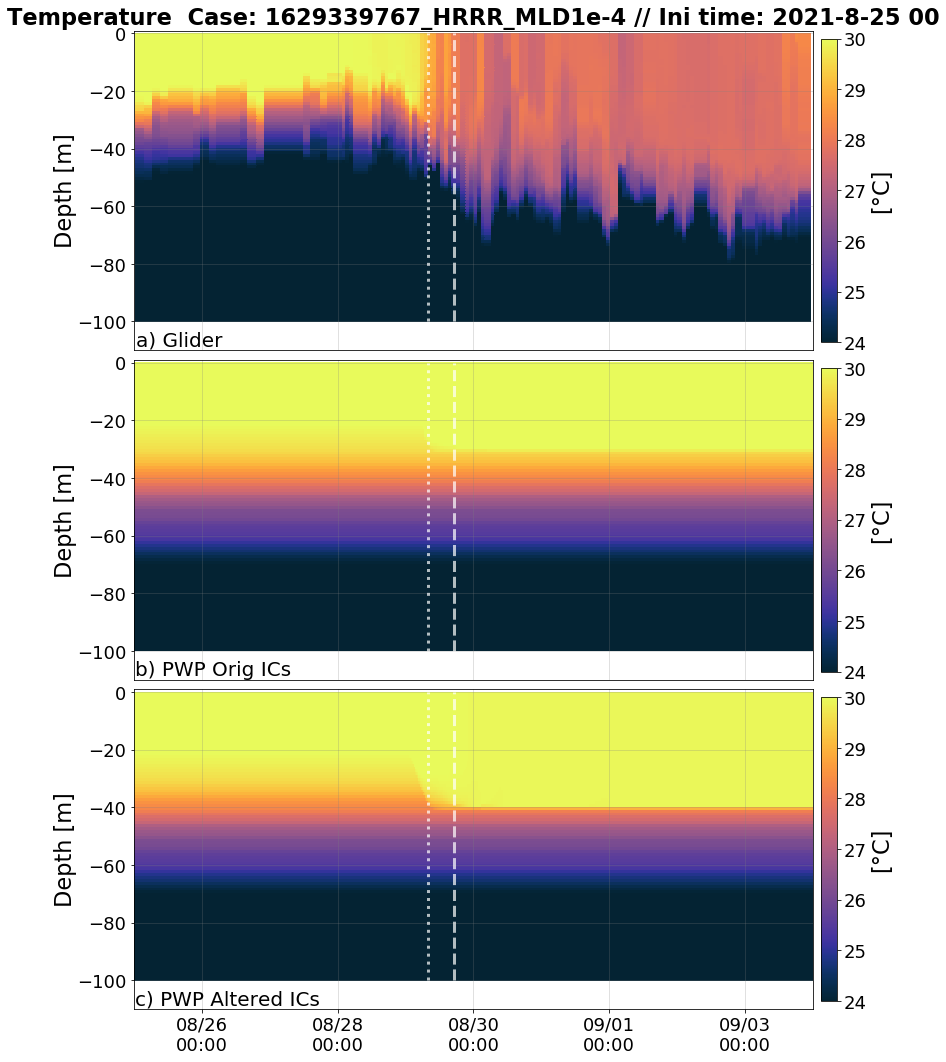

In [6]:
n = 3
fig = plt.figure(figsize=(14.5,n*6))#,constrained_layout=True)
gs = fig.add_gridspec(n,1,hspace=0.03)
ax = []
ax = [fig.add_subplot(cell) for cell in gs ];

scat_size=8
ylims = (-110,1)
minslp_kwargs = {'LineStyle':':', 'linewidth':4, 'alpha':0.9, 'color':'black', 'zorder':10}
ann_kwargs = {'fontsize':20, 'va':'bottom', 'ha':'left'}
y_label_kw = {'labelpad':0}
cb_kw={'pad':0.01, 'shrink':0.95}
tlims = (24,30)
########################################################
## Glider data
# Plot var
cur_plot = ax[0].pcolormesh(time_grid, depth_grid, temp, cmap=cmo.thermal, vmin=tlims[0], vmax=tlims[1])

# Format plot
ax[0].set_ylabel('Depth [m]', **y_label_kw)
ax[0].grid(True, alpha=0.3, color='grey')
ax[0].set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(tend)])
ax[0].set_ylim(ylims)
ax[0].xaxis.set_major_formatter(myFmtlong)
ax[0].tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
ax[0].annotate('a) Glider',(time_grid[0,0],ylims[0]),xycoords='data', **ann_kwargs) 
cbar = fig.colorbar(cur_plot,label='[°C]',ax=ax[0], **cb_kw,)
########################################################

########################################################
## PWP with original ICs
# Plot var
cur_plot = ax[1].pcolormesh(pwp_orig['tgrid'], -pwp_orig['zgrid'], pwp_orig['temp'], cmap=cmo.thermal, vmin=tlims[0], vmax=tlims[1])

# Format plot
ax[1].set_ylabel('Depth [m]', **y_label_kw)
ax[1].grid(True, alpha=0.3, color='grey')
ax[1].set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(tend)])
ax[1].set_ylim(ylims)
ax[1].xaxis.set_major_formatter(myFmtlong)
ax[1].tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
ax[1].annotate('b) PWP Orig ICs',(pwp_orig['tgrid'][0,2],ylims[0]),xycoords='data', **ann_kwargs) 
cbar = fig.colorbar(cur_plot,label='[°C]',ax=ax[1], **cb_kw,)
########################################################

########################################################
## PWP with altered ICs
# Plot var
cur_plot = ax[2].pcolormesh(pwp_altr['tgrid'], -pwp_altr['zgrid'], pwp_altr['temp'], cmap=cmo.thermal, vmin=tlims[0], vmax=tlims[1])

# Format plot
ax[2].set_ylabel('Depth [m]', **y_label_kw)
ax[2].grid(True, alpha=0.3, color='grey')
ax[2].set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(tend)])
ax[2].set_ylim(ylims)
ax[2].xaxis.set_major_formatter(myFmtlong)
ax[2].tick_params(labelbottom = True, bottom = True) # Remove bottom tick marks and labels
ax[2].annotate('c) PWP Altered ICs',(pwp_orig['tgrid'][0,2],ylims[0]),xycoords='data', **ann_kwargs) 
cbar = fig.colorbar(cur_plot,label='[°C]',ax=ax[2], **cb_kw,)
########################################################
# Plot landfall time and peak wind speed (HRRR) time
for axis in ax:
    axis.plot((mdates.datestr2num(peakWindTime),mdates.datestr2num(peakWindTime)), (-100,0), 'w:', lw=3, alpha=0.7)
    axis.plot((mdates.datestr2num(landfallTime),mdates.datestr2num(landfallTime)), (-100,0), 'w--', lw=3, alpha=0.7)

ax[0].set_title('Temperature  Case: '+case+' // Ini time: '+tstart[0:12], weight='bold')
if savefigs:
    plt.savefig('/Users/coakley/Github/Ida/data/figures/pwp_glider_transect_comparisons/T_transects_'+case+'.png',bbox_inches='tight')

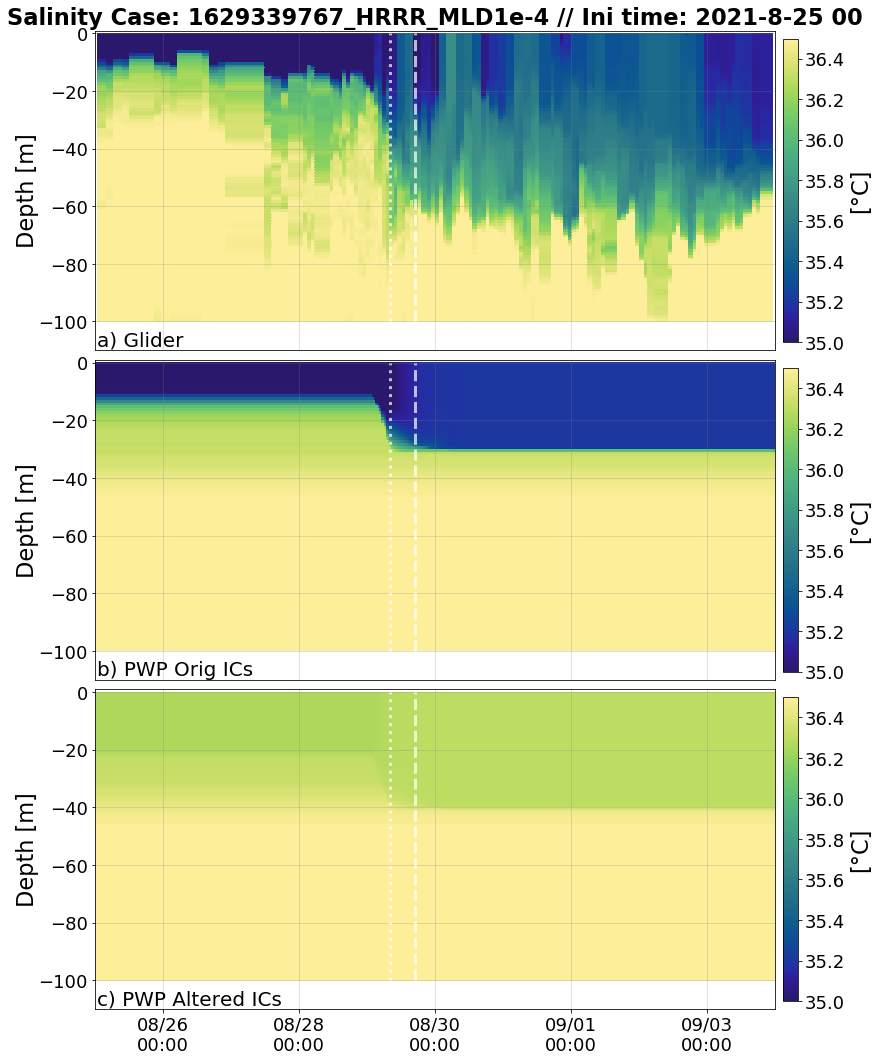

In [7]:
n = 3
fig = plt.figure(figsize=(14.5,n*6))#,constrained_layout=True)
gs = fig.add_gridspec(n,1,hspace=0.03)
ax = []
ax = [fig.add_subplot(cell) for cell in gs ];

scat_size=8
ylims = (-110,1)
minslp_kwargs = {'LineStyle':':', 'linewidth':4, 'alpha':0.9, 'color':'black', 'zorder':10}
ann_kwargs = {'fontsize':20, 'va':'bottom', 'ha':'left'}
y_label_kw = {'labelpad':0}
cb_kw={'pad':0.01, 'shrink':0.95}
slims = (35,36.5)

########################################################
## Glider data
# Plot var
cur_plot = ax[0].pcolormesh(time_grid, depth_grid, sal, cmap=cmo.haline, vmin=slims[0], vmax=slims[1])

# Format plot
ax[0].set_ylabel('Depth [m]', **y_label_kw)
ax[0].grid(True, alpha=0.3, color='grey')
ax[0].set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(tend)])
ax[0].set_ylim(ylims)
ax[0].xaxis.set_major_formatter(myFmtlong)
ax[0].tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
ax[0].annotate('a) Glider',(time_grid[0,0],ylims[0]),xycoords='data', **ann_kwargs) 
cbar = fig.colorbar(cur_plot,label='[°C]',ax=ax[0], **cb_kw,)
########################################################

########################################################
## PWP with original ICs
# Plot var
cur_plot = ax[1].pcolormesh(pwp_orig['tgrid'], -pwp_orig['zgrid'], pwp_orig['sal'], cmap=cmo.haline, vmin=slims[0], vmax=slims[1])

# Format plot
ax[1].set_ylabel('Depth [m]', **y_label_kw)
ax[1].grid(True, alpha=0.3, color='grey')
ax[1].set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(tend)])
ax[1].set_ylim(ylims)
ax[1].xaxis.set_major_formatter(myFmtlong)
ax[1].tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
ax[1].annotate('b) PWP Orig ICs',(pwp_orig['tgrid'][0,2],ylims[0]),xycoords='data', **ann_kwargs) 
cbar = fig.colorbar(cur_plot,label='[°C]',ax=ax[1], **cb_kw,)
########################################################

########################################################
## PWP with altered ICs
# Plot var
cur_plot = ax[2].pcolormesh(pwp_altr['tgrid'], -pwp_altr['zgrid'], pwp_altr['sal'], cmap=cmo.haline, vmin=slims[0], vmax=slims[1])

# Format plot
ax[2].set_ylabel('Depth [m]', **y_label_kw)
ax[2].grid(True, alpha=0.3, color='grey')
ax[2].set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(tend)])
ax[2].set_ylim(ylims)
ax[2].xaxis.set_major_formatter(myFmtlong)
ax[2].tick_params(labelbottom = True, bottom = True) # Remove bottom tick marks and labels
ax[2].annotate('c) PWP Altered ICs',(pwp_orig['tgrid'][0,2],ylims[0]),xycoords='data', **ann_kwargs) 
cbar = fig.colorbar(cur_plot,label='[°C]',ax=ax[2], **cb_kw,)
########################################################
# Plot landfall time and peak wind speed (HRRR) time
for axis in ax:
    axis.plot((mdates.datestr2num(peakWindTime),mdates.datestr2num(peakWindTime)), (-100,0), 'w:', lw=3, alpha=0.7)
    axis.plot((mdates.datestr2num(landfallTime),mdates.datestr2num(landfallTime)), (-100,0), 'w--', lw=3, alpha=0.7)
ax[0].set_title('Salinity Case: '+case+' // Ini time: '+tstart[0:12], weight='bold')
if savefigs:
    plt.savefig('/Users/coakley/Github/Ida/data/figures/pwp_glider_transect_comparisons/S_transects_'+case+'.png',bbox_inches='tight')

/Users/coakley/opt/anaconda3/envs/pangeo/lib/python3.7/site-packages/matplotlib/mathtext.py:2542: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


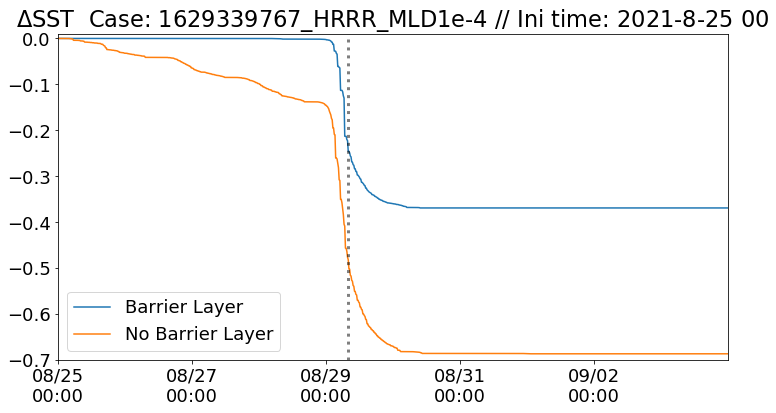

In [8]:
plt.figure(figsize=(12,6))
ylims = (-0.7,0.01)
#xticks = np.arange(mdates.datestr2num(tstart),mdates.datestr2num(landfallTime),0.5)
xticks = np.arange(mdates.datestr2num(tstart),mdates.datestr2num(tend),2)

# plt.plot(time_grid[0,:], temp[0,:], label='Glider'
plt.plot(pwp_orig['tgrid'][0,:], pwp_orig['temp'][0,:]-pwp_orig['temp'][0,0], label='Barrier Layer')
# plt.plot(pwp_orig['tgrid'][0,:], 1.85*(pwp_orig['temp'][0,:]-pwp_orig['temp'][0,0]), label='Barrier Layer')
plt.plot(pwp_altr['tgrid'][0,:], pwp_altr['temp'][0,:]-pwp_altr['temp'][0,0], label='No Barrier Layer')
plt.title('$\Delta$SST  Case: '+case+' // Ini time: '+tstart[0:12])
plt.gca().xaxis.set_major_formatter(myFmtlong)
# plt.xlim([mdates.datestr2num(tstart),mdates.datestr2num(landfallTime)])
plt.xlim([mdates.datestr2num(tstart),mdates.datestr2num(tend)])
plt.ylim(ylims)
plt.xticks(xticks)

# Plot landfall time and peak wind speed (HRRR) time
plt.plot((mdates.datestr2num(peakWindTime),mdates.datestr2num(peakWindTime)), ylims, 'k:', lw=3, alpha=0.5)
# plt.plot((mdates.datestr2num(landfallTime),mdates.datestr2num(landfallTime)), ylims, 'k--', lw=3, alpha=0.5)
plt.legend(loc='lower left')
if savefigs:
    plt.savefig('/Users/coakley/Github/Ida/data/figures/pwp_results/SST_change_timeseries_'+case+'.png',bbox_inches='tight')



In [9]:
print('BL case max SST cooling: ' + str(np.nanmin(pwp_orig['temp'][0,:]-pwp_orig['temp'][0,0])))
print('NBL case max SST cooling: ' + str(np.nanmin(pwp_altr['temp'][0,:]-pwp_altr['temp'][0,0])))

BL case max SST cooling: -0.36900970389957877
NBL case max SST cooling: -0.6864939527722882


# Calculate surface heat flux for the PWP barrier layer (original) and no barrier layer (altered) cases.

In [10]:
def bulk_lhf_shf(airP,airT,relHum,SST,windSpd):
    '''Calculate latent heat flux and sensible heat flux (+) into the atmosphere. 
    Units:
    airP [hPa]: air pressure
    airT, SST [°C]: air and sea surface temperature
    relHum [%]: relative humidity
    windSpd [m/s]: wind speed 
    Based on bulk.m and Fairall 1996'''
    
    rhoa = 1.22 # kg m^-3
    cp_air = 1004 # J kg^-1 °C^-1
    l_vap = 2.5*10**6 # J kg^-1
    
    # Coefficient of enthalpy exchange following (Park et al, 2019; Jaimes et al, 2015)
    Ck = np.asarray((1.5 - 0.25*windSpd)*10**(-3)) # for wind <2 m s^-1
    midind = (windSpd>= 2) & (windSpd< 10)
    Ck[midind] = np.asarray((0.975 + 0.0125*windSpd[midind])*10**(-3))
    hiind = (windSpd>= 10)
    Ck[hiind] = np.asarray(1.1*10**(-3))
    
    ################ Calculate qsat for air following qsat function in bulk.m ################
    ew = 6.11210 * ( 1.0007 + 3.46*10**(-6) * airP ) * np.exp(17.502*airT/(240.97+airT)); # in mb
    qsat_air  = 0.62197 * ew / ( airP - 0.378*ew );                         # mb -> kg/kg

    # Calculate q following bulk.m
    qair = 0.01 * relHum * qsat_air

    ################ Calculate qsat for surface following qsat function in bulk.m ################
    ew = 6.11210 * ( 1.0007 + 3.46*10**(-6) * airP ) * np.exp(17.502*SST/(240.97+SST)); # in mb
    qsat_surf  = 0.62197 * ew / ( airP - 0.378*ew );                         # mb -> kg/kg
    
    shf = np.asarray(rhoa * cp_air * Ck * windSpd * (SST - airT)) #
    lhf = rhoa * l_vap * Ck * windSpd * (qsat_surf - qair) #
    
    fluxes= {'lhf':lhf, 'shf':shf, 'qsat_surf':qsat_surf, 'qair':qair}
    
    return fluxes

In [11]:
def load_hrrr(start_date, end_date, buoy, point_location, height):
    '''
    Written by Jaden Dicopoulos
    Load in HRRR data from a RU repository
    '''
    #directory = '/Volumes/home/jad438/validation_data/hrrrdata/'
    directory='/Users/coakley/Github/Ida/data/forcing/hrrr/'
    sites = pd.read_csv(point_location, skipinitialspace=True)
    time_span_D = pd.date_range(start_date, end_date-timedelta(hours=23), freq='D')  #  -timedelta(days=1) was removed from here
    hrrr_ws = []
    hrrr_EWwind = []
    hrrr_NWwind = []
    hrrr_dt = np.empty((0,), dtype='datetime64[m]')
    hrrr_height = []
    for ind, date in enumerate(time_span_D):
        file = 'hrrr_data_' + date.strftime("%Y%m%d") + '.nc'
        try:
            hrrr_ds = xr.open_dataset(directory + file)
            lats = hrrr_ds.gridlat_0.squeeze()
            lons = hrrr_ds.gridlon_0.squeeze()
            site_code = sites[sites['name'] == buoy].index[0]
            a = abs(lats - sites.latitude[site_code]) + abs(lons - sites.longitude[site_code])
            i, j = np.unravel_index(a.argmin(), a.shape)
            
            hrrr_ws = np.append(hrrr_ws, hrrr_ds.wind_speed[:, height, i, j])
            hrrr_dt = np.append(hrrr_dt, hrrr_ds.time)
            hrrr_EWwind = np.append(hrrr_EWwind, hrrr_ds.eastward_wind[:, height, i, j])
            hrrr_NWwind = np.append(hrrr_NWwind, hrrr_ds.northward_wind[:, height, i, j])
            hrrr_height = np.append(hrrr_height, hrrr_ds.lv_HTGL1[height])

        except:
            time_span_H = pd.date_range(date, date + timedelta(hours=23), freq='H')
            hrrr_ws = np.append(hrrr_ws, np.empty(shape=(len(time_span_H))) * np.NAN)
            hrrr_dt = np.append(hrrr_dt, time_span_H)
            hrrr_EWwind = np.append(hrrr_EWwind, np.empty(shape=(len(time_span_H))) * np.NAN)
            hrrr_NWwind = np.append(hrrr_NWwind, np.empty(shape=(len(time_span_H))) * np.NAN)
            hrrr_height = np.append(hrrr_height, np.NAN)

    return hrrr_ws, hrrr_EWwind, hrrr_NWwind, hrrr_dt, hrrr_height

In [12]:
# Hold air temp, pressure and relative humidity constant between the two cases.
air_temp = 30 * np.ones_like(pwp_orig['temp'][0,:]) # 30°C for air temp in August in the Gulf
air_pres = 1000 * np.ones_like(pwp_orig['temp'][0,:])# hPa
# RH = 100 * np.ones_like(pwp_orig['temp'][0,:])# 
RH = 90 * np.ones_like(pwp_orig['temp'][0,:])# 

# Grab wind speeds
glider = 'ng645'
if profileID == 1629339767:
    glider_location = '/Users/coakley/Github/Ida/data/forcing/glider_location_close.csv'

height = 0 
wind_t0 = tstart_dt
wind_t1 =  tend_dt
hrrr_windSpeed, hrrr_EWwind, hrrr_NWwind, hrrr_time, hrrr_height = load_hrrr(wind_t0, wind_t1, glider, glider_location, height)

# Interpolate the winds to the pwp timestep
windspdF = interp1d(mdates.date2num(hrrr_time),hrrr_windSpeed, fill_value='extrapolate')
winds_pwpTime = windspdF(pwp_orig['tgrid'][0,:])


orig_fluxes = bulk_lhf_shf(air_pres,air_temp,RH, pwp_orig['temp'][0,:].values, winds_pwpTime)
altr_fluxes = bulk_lhf_shf(air_pres,air_temp,RH, pwp_altr['temp'][0,:].values, winds_pwpTime)

Total Ahead of Landfall heat flux change due to the barrier layer: 1532.705 kJ/m2
Total Ahead  of Landfall heat transport (Barrier Layer Case) : 10359.473 kJ/m2
Total Ahead  of Landfall heat transport (No Barrier Layer Case): 8826.768 kJ/m2
% change in ahead of Landfall heat transport ((Change in heat transport) / (BL Total heat transport)): 14.8%


/Users/coakley/opt/anaconda3/envs/pangeo/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal


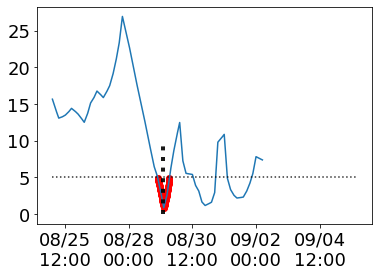

In [13]:
if profileID == 1629339767:
    # Find a time when the profile is within X RMW's and integrate the heat fluxes over that
    # This csv has the distance between the storm and the profile location calculated in RMW and km.
    # These data were calculatd using IbTracs data and the lat lon from the profile
    dist_df = pd.read_csv('/Users/coakley/Github/Ida/data/prof2ida_dist_data_prof1629339767.csv')

    # Interpolate to pwp time
    f_distRMW = interp1d(dist_df['ida_datenum'].values,dist_df['profdist2idaRMW'].values, kind='linear', bounds_error=False)
    f_distKM = interp1d(dist_df['ida_datenum'].values,dist_df['profdist2idaKM'].values, kind='linear', bounds_error=False)

    pwp_dist2IdaRMW = f_distRMW(pwp_orig['tgrid'][0,:])
    pwp_dist2IdaKM = f_distKM(pwp_orig['tgrid'][0,:])
    plt.plot(pwp_orig['tgrid'][0,:],pwp_dist2IdaRMW)
    plt.plot((pwp_orig['tgrid'][0,0],pwp_orig['tgrid'][0,-1]),(5,5),c='k',alpha=0.8,ls=':')
    plt.gca().xaxis.set_major_formatter(myFmtlong)
    plt.plot((mdates.datestr2num(peakWindTime),mdates.datestr2num(peakWindTime)), (0,10), **minslp_kwargs)

#     plt.xlim([mdates.datestr2num('2021-08-28 00:00'),mdates.datestr2num('2021-08-30 00:00')])
    
    xRMW= 5
    ind = np.where((pwp_dist2IdaRMW <= xRMW) & (pwp_orig['tgrid'][0,:] <mdates.datestr2num(landfallTime)))[0]
    plt.scatter(pwp_orig['tgrid'][0,ind],pwp_dist2IdaRMW[ind], c='r')
    
    ## Do the % change calculation
    # Calculate the total change in the surface heat flux (LHF + SHF)
    total_hf_diff = (orig_fluxes['lhf'] - altr_fluxes['lhf']) + (orig_fluxes['shf'] - altr_fluxes['shf'])
    integrated_heatFluxChange = np.nansum(total_hf_diff[ind]) * 900 # dt= 15min = 900s
    
    # Find the total heat flux during that time 
    total_hf_orig = orig_fluxes['lhf']+orig_fluxes['shf']
    total_hf_altr = altr_fluxes['lhf']+altr_fluxes['shf']

    integrated_THF_orig = np.nansum(total_hf_orig[ind]) * 900 # dt= 15min = 900s
    integrated_THF_altr = np.nansum(total_hf_altr[ind]) * 900 # dt= 15min = 900s
    print('Total Ahead of Landfall heat flux change due to the barrier layer: '+ str(np.round(integrated_heatFluxChange/1000,3)) +' kJ/m2')
    print('Total Ahead  of Landfall heat transport (Barrier Layer Case) : ' + str(np.round(integrated_THF_orig/1000,3)) +' kJ/m2')
    print('Total Ahead  of Landfall heat transport (No Barrier Layer Case): ' + str(np.round(integrated_THF_altr/1000,3)) +' kJ/m2')

    print('% change in ahead of Landfall heat transport ((Change in heat transport) / (BL Total heat transport)): ' + 
          str(np.round(100*(integrated_heatFluxChange/integrated_THF_orig),2)) + '%')

In [14]:
peakWindTime

'2021-08-29T08:00:00'

In [15]:
# Time the storm was with in xRMW 
print(xRMW)
print(mdates.num2date(np.nanmin(pwp_orig['tgrid'][0,ind])))
print(mdates.num2date(np.nanmax(pwp_orig['tgrid'][0,ind])))

5
2021-08-29 03:15:00+00:00
2021-08-29 14:15:00+00:00


In [16]:
landfallTime

'2021-08-29T17:00:00'

The storm is within 5RMW of the profile for 11 hours and it leaves that window just 3 hours before making landfall.

# Figure 2: Temperature and Salinity initial conditions


In [17]:
## Find initial MLD based on Rudzin 2018 Eq1
thresh = 0.5
# Calculate the initial rho profile
ini_rho = sw.dens(pwp_orig['sal'][:,0],pwp_orig['temp'][:,0],pwp_orig['z_vector'])
# Calculate density at 2m depth
rho_2m = sw.dens(pwp_orig['sal'][2,0],pwp_orig['temp'][2,0],2)
# Calculate the density if the temp was 0.5°C cooler
rho_mld = sw.dens(pwp_orig['sal'][2,0],pwp_orig['temp'][2,0] - thresh,2)

# Find where the initial rho profile == the mld rho
mld = pwp_orig['z_vector'][np.argmin(np.abs(ini_rho-(rho_mld)))]

# isothermal layer depth defined by Rudzin 2018
ild = -pwp_orig['z_vector'][(np.abs(pwp_orig['temp'][:,0] - pwp_orig['temp'][0,0]) > thresh)][0] 

print(ild)
print(mld)

<xarray.DataArray 'z_vector' ()>
array(-19)
<xarray.DataArray 'z_vector' ()>
array(3)


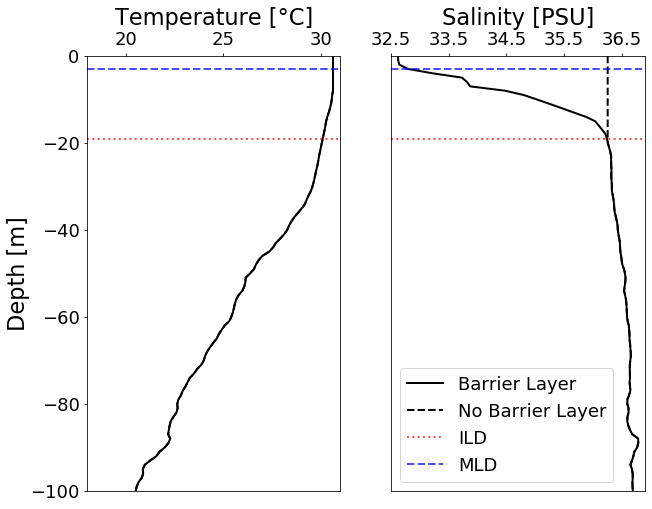

In [18]:
n = 2
# fig = plt.figure(figsize=(12,8))
fig = plt.figure(figsize=(10,8))

gs = fig.add_gridspec(1,n)
ax = []
ax = [fig.add_subplot(cell) for cell in gs ];

y_label_kw = {'labelpad':0}
ylims = (-100, 0)
orig_kw = {'color': 'k', 'ls':'-', 'label':'Barrier Layer', 'lw':2}
altr_kw = {'color': 'k', 'ls':'--', 'label':'No Barrier Layer', 'lw':2}
ild_kw={'color': 'r', 'ls':':', 'label':'ILD', 'alpha':0.7, 'lw':2}
mld_kw={'color': 'b', 'ls':'--', 'label':'MLD', 'alpha':0.7, 'lw':2}

########################################################
## Plot temperature ICs
xlims =(18,31)
ax[0].plot(pwp_orig['temp'][:,0],-pwp_orig['z_vector'], **orig_kw)
ax[0].plot(pwp_altr['temp'][:,0],-pwp_orig['z_vector'], **altr_kw)
ax[0].plot(xlims, (ild,ild),  **ild_kw)
ax[0].plot(xlims, (-mld,-mld), **mld_kw)
# ax[0].plot(xlims, (_ild,_ild),  **ild_kw)
# ax[0].plot(xlims, (-_mld,-_mld), **mld_kw)


# Format plot
ax[0].set_ylabel('Depth [m]', **y_label_kw)
ax[0].set_xlim(xlims)
ax[0].set_ylim(ylims)
ax[0].spines['top']
ax[0].set_title('Temperature [°C]')
ax[0].tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
ax[0].tick_params(labeltop = True, top = True) # Add top tick marks and labels
# ax[0].legend()
# ax[0].grid(axis='y')
########################################################

########################################################
## Plot salinity ICs
xlims =(32.5,36.9)
ax[1].plot(pwp_orig['sal'][:,0],-pwp_orig['z_vector'], **orig_kw)
ax[1].plot(pwp_altr['sal'][:,0],-pwp_orig['z_vector'], **altr_kw)
ax[1].plot(xlims, (ild,ild), **ild_kw)
ax[1].plot(xlims, (-mld,-mld), **mld_kw)

# Format plot
# ax[1].set_ylabel('Depth [m]', **y_label_kw)
ax[1].set_xlim(xlims)
ax[1].set_ylim(ylims)
ax[1].spines['top']
ax[1].set_xticks(np.arange(xlims[0],xlims[1],1))
ax[1].set_title('Salinity [PSU]')
ax[1].tick_params(labelleft = False, left = False) # Remove bottom tick marks and labels
ax[1].tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
ax[1].tick_params(labeltop = True, top = True) # Add top tick marks and labels
# ax[1].grid(axis='y')
ax[1].legend(loc='lower left')
########################################################
# plt.suptitle('Initial conditions Case: '+case+' // Ini time: '+tstart[0:12],y=1.05)
# plt.tight_layout()
# plt.savefig('/Users/coakley/Github/Ida/data/figures/figure1_initialConditions_ICs_for_BL_NBL_cases_'+case+'.png',bbox_inches='tight')
if savefigs:
    plt.savefig('/Users/coakley/Github/Ida/data/figures/initialConditions_ICs_for_BL_NBL_cases_'+case+'.png',bbox_inches='tight')

# Figure 4 PWP transects

1629339767_HRRR_MLD1e-4
altr


/Users/coakley/opt/anaconda3/envs/pangeo/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/Users/coakley/opt/anaconda3/envs/pangeo/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/Users/coakley/opt/anaconda3/envs/pangeo/lib/python3.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: divide by zero encountered in true_divide
/Users/coakley/opt/anaconda3/envs/pangeo/lib/python3.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in true_divide


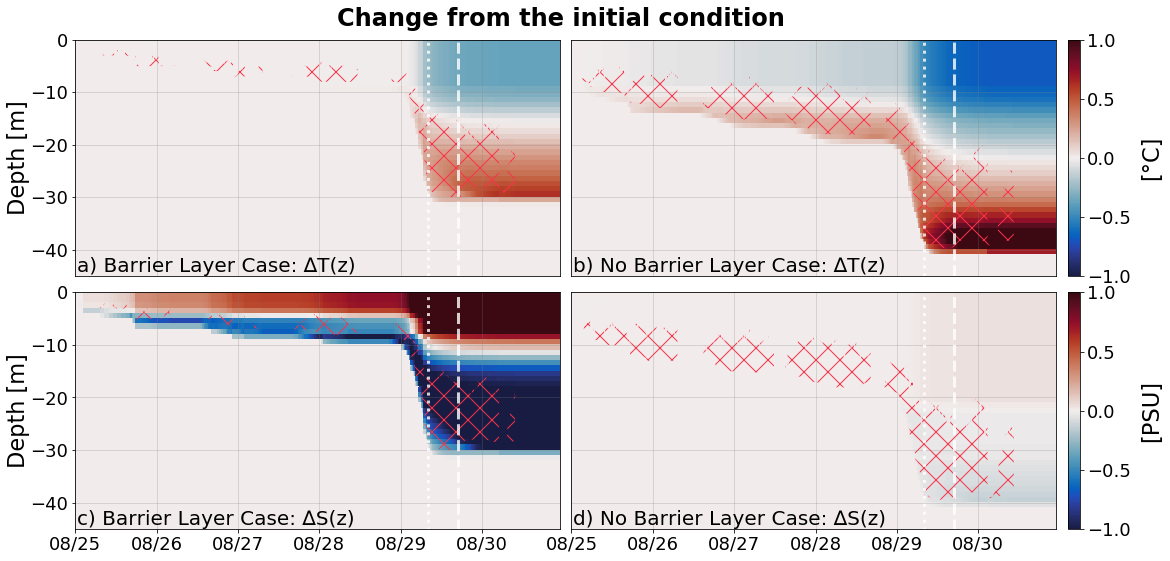

In [19]:
# Make one consolidated change from IC figure
####
from numpy.matlib import repmat
fig = plt.figure(figsize=(18,9))#,constrained_layout=True)
gs = fig.add_gridspec(2,3,hspace=0.07, wspace=0.035, width_ratios=(1,1,0.025))

ylims = (-45,0)
minslp_kwargs = {'LineStyle':':', 'linewidth':4, 'alpha':0.9, 'color':'black', 'zorder':10}
ann_kwargs = {'fontsize':20, 'va':'bottom', 'ha':'left'}
y_label_kw = {'labelpad':0}
cb_kw={'pad':0.01, 'shrink':0.95}
# contourkw = {'colors':'gold'}
contourkw = {'colors':'none','hatches':'x'}
colors = ['#FB334A']

peakWindkw={'color':'white','alpha':0.8,'linestyle':':','lw':3}
Landfallkw={'color':'white','alpha':0.8,'linestyle':'--', 'lw':3}

_tend = "2021 08 30 23:00"
############################################################# BL CASE #############################################################
# Plot the BL case first then repeat for the NBL case
##### Set up data
origaltr='orig'
if origaltr=='orig':
    pwptnum=pwp_orig['tgrid']
    pwpz = pwp_orig['zgrid']
    pwptemp = pwp_orig['temp']
    pwpsal = pwp_orig['sal']
    pwpdens = pwp_orig['dens']
    pwpuvel = pwp_orig['uvel']
    pwpvvel = pwp_orig['vvel']
    pwptimevec=pwp_orig['tgrid'][0,:]
    print(case)
    
if origaltr=='altr':
    pwptnum=pwp_altr['tgrid']
    pwpz = pwp_altr['zgrid']
    pwptemp = pwp_altr['temp']
    pwpsal = pwp_altr['sal']
    pwpdens = pwp_altr['dens']
    pwpuvel = pwp_altr['uvel']
    pwpvvel = pwp_altr['vvel']
    pwptimevec=pwp_altr['tgrid'][0,:]
    print('altr')

# Calculate shear, N**2, reduced_shear
diffKwargs = {'axis':0, 'append':np.nan}
shear = np.sqrt((np.diff(pwpuvel, **diffKwargs)/np.diff(-pwpz, **diffKwargs))**2 + (np.diff(pwpvvel, **diffKwargs)/np.diff(-pwpz, **diffKwargs))**2)
N2 = (-9.81/1025)*(np.diff(pwpdens, **diffKwargs)/np.diff(-pwpz, **diffKwargs))

Rig = N2/(shear**2)

Rig[np.isinf(Rig)] = Rig[np.isfinite(Rig)].max()
red_shear =  (1/4)*(1/Rig)

########################################################
## Temperature cross section
tlims = (-1,1)
_ax = fig.add_subplot(gs[0,0])

# Plot var
cur_plot = _ax.pcolormesh(pwptnum, -pwpz, pwptemp-repmat(pwptemp[:,0], np.shape(pwptemp)[1],1).T, cmap=cmo.balance, vmin=tlims[0], vmax=tlims[1])

# Add contour of critical rich num value
# _ax.contour(pwptnum[:-1,:], -pwpz[:-1,:], Rig[:-1,:], levels=[0, .3], **contourkw)
cs = _ax.contourf(pwptnum[:-1,:], -pwpz[:-1,:], Rig[:-1,:], levels=[0, .3], **contourkw)
# ------------------------------
# New bit here that handles changing the color of hatches
# For each level, we set the color of its hatch 
for i, collection in enumerate(cs.collections):
    collection.set_edgecolor(colors[i % len(colors)])
# Doing this also colors in the box around each level
# We can remove the colored line around the levels by setting the linewidth to 0
for collection in cs.collections:
    collection.set_linewidth(0.)
# ------------------------------

# Format plot
_ax.set_ylabel('Depth [m]', **y_label_kw)
# ax[0].set_title('Temperature')
_ax.grid(True, alpha=0.3, color='grey')
_ax.set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(_tend)])
_ax.set_ylim(ylims)
_ax.xaxis.set_major_formatter(myFmtlong)
_ax.tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
_ax.plot((mdates.datestr2num(peakWindTime),mdates.datestr2num(peakWindTime)), [-100,0], **peakWindkw)
_ax.plot((mdates.datestr2num(landfallTime),mdates.datestr2num(landfallTime)), [-100,0], **Landfallkw)
_ax.annotate('a) Barrier Layer Case: ∆T(z)',(pwptimevec[2],ylims[0]),xycoords='data', **ann_kwargs) 
# cbar = fig.colorbar(cur_plot,label='[°C]',ax=ax[0], **cb_kw,)
# cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])  # horizontal colorbar
# fig.colorbar(cur_plot,label='[°C]',ax=ax[0], **cb_kw)

########################################################

########################################################
## Salinity cross section
Slims = (-1,1)
_ax = fig.add_subplot(gs[1,0])
# Plot var
cur_plot = _ax.pcolormesh(pwptnum, -pwpz, pwpsal-repmat(pwpsal[:,0], np.shape(pwpsal)[1],1).T, cmap=cmo.balance, vmin=Slims[0], vmax=Slims[1])

# Add contour of critical rich num value
# _ax.contour(pwptnum[:-1,:], -pwpz[:-1,:], Rig[:-1,:], levels=[0, .3], **contourkw)
cs = _ax.contourf(pwptnum[:-1,:], -pwpz[:-1,:], Rig[:-1,:], levels=[0, .3], **contourkw)
# ------------------------------
# New bit here that handles changing the color of hatches
# For each level, we set the color of its hatch 
for i, collection in enumerate(cs.collections):
    collection.set_edgecolor(colors[i % len(colors)])
# Doing this also colors in the box around each level
# We can remove the colored line around the levels by setting the linewidth to 0
for collection in cs.collections:
    collection.set_linewidth(0.)
# ------------------------------


# Format plot
_ax.set_ylabel('Depth [m]', **y_label_kw)
# ax[0].set_title('Temperature')
_ax.grid(True, alpha=0.3, color='grey')
_ax.set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(_tend)])
_ax.set_ylim(ylims)
_ax.xaxis.set_major_formatter(myFmt)
# ax[1].tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
_ax.plot((mdates.datestr2num(peakWindTime),mdates.datestr2num(peakWindTime)), [-100,0], **peakWindkw)
_ax.plot((mdates.datestr2num(landfallTime),mdates.datestr2num(landfallTime)), [-100,0], **Landfallkw)
_ax.annotate('c) Barrier Layer Case: ∆S(z)',(pwptimevec[2],ylims[0]),xycoords='data', **ann_kwargs) 

# cbar = fig.colorbar(cur_plot,label='[PSU]',ax=ax[1],  **cb_kw,)
# cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])  # horizontal colorbar
# fig.colorbar(cur_plot,label='[°C]',ax=ax[0], **cb_kw)
########################################################
####################################################################################################################################

############################################################# NBL CASE #############################################################
##### Set up data
origaltr='altr'
if origaltr=='orig':
    pwptnum=pwp_orig['tgrid']
    pwpz = pwp_orig['zgrid']
    pwptemp = pwp_orig['temp']
    pwpsal = pwp_orig['sal']
    pwpdens = pwp_orig['dens']
    pwpuvel = pwp_orig['uvel']
    pwpvvel = pwp_orig['vvel']
    pwptimevec=pwp_orig['tgrid'][0,:]
    print(case)
    
if origaltr=='altr':
    pwptnum=pwp_altr['tgrid']
    pwpz = pwp_altr['zgrid']
    pwptemp = pwp_altr['temp']
    pwpsal = pwp_altr['sal']
    pwpdens = pwp_altr['dens']
    pwpuvel = pwp_altr['uvel']
    pwpvvel = pwp_altr['vvel']
    pwptimevec=pwp_altr['tgrid'][0,:]
    print('altr')

# Calculate shear, N**2, reduced_shear
diffKwargs = {'axis':0, 'append':np.nan}
shear = np.sqrt((np.diff(pwpuvel, **diffKwargs)/np.diff(-pwpz, **diffKwargs))**2 + (np.diff(pwpvvel, **diffKwargs)/np.diff(-pwpz, **diffKwargs))**2)
N2 = (-9.81/1025)*(np.diff(pwpdens, **diffKwargs)/np.diff(-pwpz, **diffKwargs))

Rig = N2/(shear**2)

Rig[np.isinf(Rig)] = Rig[np.isfinite(Rig)].max()
red_shear =  (1/4)*(1/Rig)

########################################################
## Temperature cross section
tlims = (-1,1)
_ax = fig.add_subplot(gs[0,1])

# Plot var
cur_plot = _ax.pcolormesh(pwptnum, -pwpz, pwptemp-repmat(pwptemp[:,0], np.shape(pwptemp)[1],1).T, cmap=cmo.balance, vmin=tlims[0], vmax=tlims[1])

# Add contour of critical rich num value
cs = _ax.contourf(pwptnum[:-1,:], -pwpz[:-1,:], Rig[:-1,:], levels=[0, .3], **contourkw)
# ------------------------------
# New bit here that handles changing the color of hatches
# For each level, we set the color of its hatch 
for i, collection in enumerate(cs.collections):
    collection.set_edgecolor(colors[i % len(colors)])
# Doing this also colors in the box around each level
# We can remove the colored line around the levels by setting the linewidth to 0
for collection in cs.collections:
    collection.set_linewidth(0.)
# ------------------------------

# Format plot
# ax[1].set_ylabel('Depth [m]', **y_label_kw)
# ax[0].set_title('Temperature')
_ax.grid(True, alpha=0.3, color='grey')
_ax.set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(_tend)])
_ax.set_ylim(ylims)
_ax.xaxis.set_major_formatter(myFmtlong)
_ax.tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
_ax.tick_params(labelleft = False, left = False) # Remove left tick marks and labels
_ax.plot((mdates.datestr2num(peakWindTime),mdates.datestr2num(peakWindTime)), [-100,0], **peakWindkw)
_ax.plot((mdates.datestr2num(landfallTime),mdates.datestr2num(landfallTime)), [-100,0], **Landfallkw)

_ax.annotate('b) No Barrier Layer Case: ∆T(z)',(pwptimevec[2],ylims[0]),xycoords='data', **ann_kwargs) 


from matplotlib.colorbar import Colorbar # For dealing with Colorbars the proper way - TBD in a separate PyCoffee ?

cbax = plt.subplot(gs[0,2])
cbar = Colorbar(ax = cbax, mappable=cur_plot)
cbar.set_label('[°C]', labelpad=10)

########################################################
########################################################
## Salinity cross section
Slims = (-1,1)
_ax = fig.add_subplot(gs[1,1])
# Plot var
cur_plot = _ax.pcolormesh(pwptnum, -pwpz, pwpsal-repmat(pwpsal[:,0], np.shape(pwpsal)[1],1).T, cmap=cmo.balance, vmin=Slims[0], vmax=Slims[1])

# Add contour of critical rich num value
# _ax.contour(pwptnum[:-1,:], -pwpz[:-1,:], Rig[:-1,:], levels=[0, .3], **contourkw)
cs = _ax.contourf(pwptnum[:-1,:], -pwpz[:-1,:], Rig[:-1,:], levels=[0, .3], **contourkw)
# ------------------------------
# New bit here that handles changing the color of hatches
# For each level, we set the color of its hatch 
for i, collection in enumerate(cs.collections):
    collection.set_edgecolor(colors[i % len(colors)])
# Doing this also colors in the box around each level
# We can remove the colored line around the levels by setting the linewidth to 0
for collection in cs.collections:
    collection.set_linewidth(0.)
# ------------------------------


# Format plot
# ax[3].set_ylabel('Depth [m]', **y_label_kw)
# ax[0].set_title('Temperature')
_ax.grid(True, alpha=0.3, color='grey')
_ax.set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(_tend)])
_ax.set_ylim(ylims)
_ax.xaxis.set_major_formatter(myFmt)
# ax[1].tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
_ax.tick_params(labelleft = False, left = False) # Remove left tick marks and labels
_ax.plot((mdates.datestr2num(peakWindTime),mdates.datestr2num(peakWindTime)), [-100,0], **peakWindkw)
_ax.plot((mdates.datestr2num(landfallTime),mdates.datestr2num(landfallTime)), [-100,0],  **Landfallkw)
_ax.annotate('d) No Barrier Layer Case: ∆S(z)',(pwptimevec[2],ylims[0]),xycoords='data', **ann_kwargs) 



cbax = plt.subplot(gs[1,2])
cbar = Colorbar(ax = cbax, mappable=cur_plot)
cbar.set_label('[PSU]', labelpad=10)

########################################################

plt.suptitle('Change from the initial condition',y=0.93,fontweight='bold')
if savefigs:
    plt.savefig('/Users/coakley/Github/Ida/data/figures/pwp_results/T-initial_S-initial_richnum_contour_OrigAndAltr_'+case+'.png',bbox_inches='tight')

In [20]:
# See when the barrier layer erodes and the SST starts to change at all
print('Initialization time: 8/25/21 00:00')
print('BL case time of first SST change:'+ str(mdates.num2date(pwp_orig['tgrid'][0,np.where((pwp_orig['temp'][0,:] - pwp_orig['temp'][0,0]) < 0)[0][0]].values)))
print('NBL case time of first SST change:'+ str(mdates.num2date(pwp_altr['tgrid'][0,np.where((pwp_altr['temp'][0,:] - pwp_altr['temp'][0,0]) < 0)[0][0]].values)))


Initialization time: 8/25/21 00:00
BL case time of first SST change:2021-08-28 01:15:00+00:00
NBL case time of first SST change:2021-08-25 03:15:00+00:00


# Figure 5: Wind stress, SST, heat flux, heat flux difference

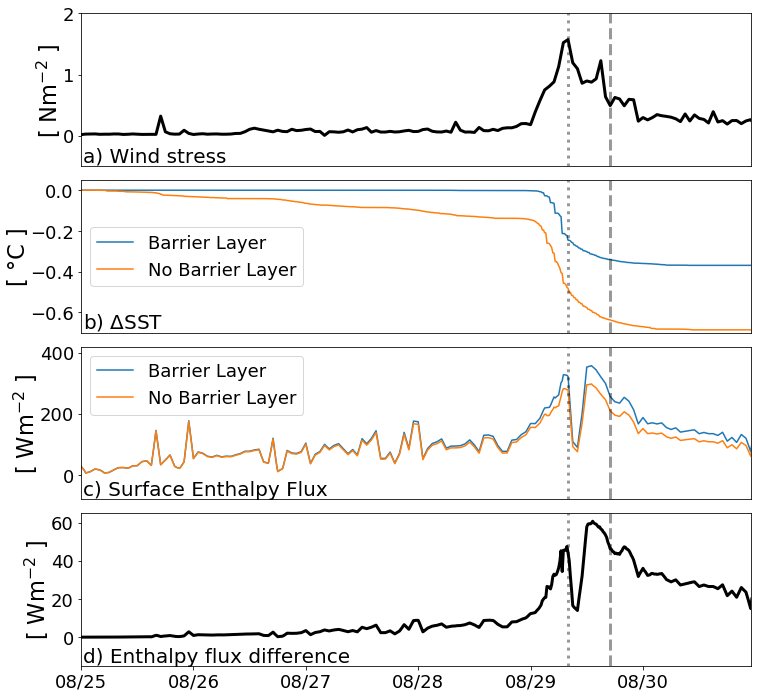

In [21]:
######### Pull forcing data #################
## Get tau from the forcing data from PWP
forcing = xr.open_dataset('/Users/coakley/Github/Ida/data/forcing/HRRR_Ida_windsOnly_'+str(profileID)+'_08-25-00_initime.nc')
tau = np.sqrt(forcing['tx'].values**2 + forcing['ty'].values**2)
# Time in the forcing data is zeroed at 8/25 00
forcing['time'] = forcing['time'] + mdates.datestr2num("2021-08-25 00:00")
#############################################


######### Format plot ########################
n = 4
fig = plt.figure(figsize=(12,12))#,constrained_layout=True)
gs = fig.add_gridspec(n,1,hspace=0.09)

ann_kwargs = {'fontsize':20, 'va':'bottom', 'ha':'left'}
y_label_kw = {'labelpad':0}
ann_kwargs = {'fontsize':20, 'va':'bottom', 'ha':'left'}
y_label_kw = {'labelpad':0}
peakWindkw={'color':'k','alpha':0.4,'linestyle':':','lw':3}
Landfallkw={'color':'k','alpha':0.4,'linestyle':'--', 'lw':3}
_tend = "2021 08 30 23:00"
xticks = np.arange(mdates.datestr2num(tstart),mdates.datestr2num(tend),1)

########################################################

########################################################
## Wind stress 
ax = fig.add_subplot(gs[0])
ylims=(-0.5,2)
ax.plot(forcing['time'].values, tau, 'k', lw=3)
ax.plot((mdates.datestr2num(peakWindTime),mdates.datestr2num(peakWindTime)), ylims, **peakWindkw)
ax.plot((mdates.datestr2num(landfallTime),mdates.datestr2num(landfallTime)), ylims, **Landfallkw)

ax.set_ylabel('[ Nm$^{-2}$ ]', **y_label_kw)
ax.set_ylim(ylims)
ax.xaxis.set_major_formatter(myFmt)
ax.set_xticks(xticks)
ax.set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(_tend)])
ax.tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
ax.annotate('a) Wind stress',(pwp_orig['tgrid'][0,2],ylims[0]),xycoords='data', **ann_kwargs) 
########################################################

########################################################
## Change in SST
ax = fig.add_subplot(gs[1])
ylims = (-0.7,0.05)
ax.plot(pwp_orig['tgrid'][0,:], pwp_orig['temp'][0,:]-pwp_orig['temp'][0,0], label='Barrier Layer')
ax.plot(pwp_altr['tgrid'][0,:], pwp_altr['temp'][0,:]-pwp_altr['temp'][0,0], label='No Barrier Layer')
ax.plot((mdates.datestr2num(peakWindTime),mdates.datestr2num(peakWindTime)), ylims, **peakWindkw)
ax.plot((mdates.datestr2num(landfallTime),mdates.datestr2num(landfallTime)), ylims, **Landfallkw)

ax.set_ylabel('[ °C ]', **y_label_kw)
ax.set_ylim(ylims)
ax.xaxis.set_major_formatter(myFmt)
ax.set_xticks(xticks)
ax.set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(_tend)])
ax.tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
ax.annotate('b) $\Delta$SST',(pwp_orig['tgrid'][0,2],ylims[0]),xycoords='data', **ann_kwargs) 
ax.legend(loc='center left')

########################################################

########################################################
## Total HF
ax = fig.add_subplot(gs[2])
# ylims=(1,220)
ylims=(-80,420)

ax.plot(pwp_orig['tgrid'][0,:], orig_fluxes['lhf']+ orig_fluxes['shf'], label='Barrier Layer')
ax.plot(pwp_orig['tgrid'][0,:], altr_fluxes['lhf']+ altr_fluxes['shf'], label='No Barrier Layer')
ax.plot((mdates.datestr2num(peakWindTime),mdates.datestr2num(peakWindTime)), ylims, **peakWindkw)
ax.plot((mdates.datestr2num(landfallTime),mdates.datestr2num(landfallTime)), ylims, **Landfallkw)

ax.set_ylabel('[ Wm$^{-2}$ ]', **y_label_kw)
ax.set_ylim(ylims)
ax.xaxis.set_major_formatter(myFmt)
ax.set_xticks(xticks)
ax.set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(_tend)])
ax.tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
ax.annotate('c) Surface Enthalpy Flux',(pwp_orig['tgrid'][0,2],ylims[0]),xycoords='data', **ann_kwargs) 
ax.legend(loc='upper left')
########################################################

########################################################
## Total HF difference
ax = fig.add_subplot(gs[3])
ylims=(-15,65)
ax.plot(pwp_orig['tgrid'][0,:], orig_fluxes['lhf']+ orig_fluxes['shf'] - (altr_fluxes['lhf']+ altr_fluxes['shf']), label='Enthalpy',c='k', lw=3)
ax.plot((mdates.datestr2num(peakWindTime),mdates.datestr2num(peakWindTime)), ylims, **peakWindkw)
ax.plot((mdates.datestr2num(landfallTime),mdates.datestr2num(landfallTime)), ylims, **Landfallkw)

# Format plot
ax.set_ylabel('[ Wm$^{-2}$ ]', **y_label_kw)
ax.set_ylim(ylims)
ax.xaxis.set_major_formatter(myFmt)
ax.set_xticks(xticks)
ax.set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(_tend)])
ax.annotate('d) Enthalpy flux difference',(pwp_orig['tgrid'][0,2],ylims[0]),xycoords='data', **ann_kwargs) 

#############################################################################################################################################################
if savefigs:
    plt.savefig('/Users/coakley/Github/Ida/data/figures/pwp_results/heatFluxes_THF_DiffTHF_RH'+str(RH[0])[0:2]+'_'+case+'.png',bbox_inches='tight')
##############################################################################################################################################################

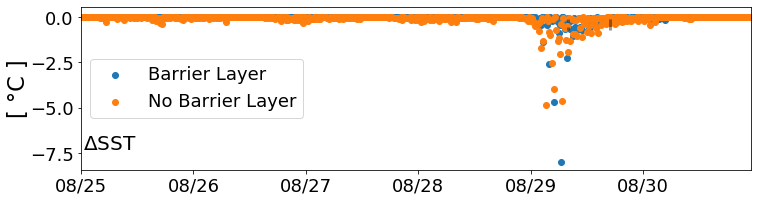

In [22]:
# Check the rates of the SST change
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(1,1,1)
ylims = (-0.7,0.05)
dSSt_dt_orig = np.append(np.diff(pwp_orig['temp'][0,:])/np.diff(pwp_orig['tgrid'][0,:]),np.nan)
dSSt_dt_altr = np.append(np.diff(pwp_altr['temp'][0,:])/np.diff(pwp_altr['tgrid'][0,:]),np.nan)

ax.scatter(pwp_orig['tgrid'][0,:], dSSt_dt_orig, label='Barrier Layer')
ax.scatter(pwp_altr['tgrid'][0,:], dSSt_dt_altr, label='No Barrier Layer')
ax.plot((mdates.datestr2num(peakWindTime),mdates.datestr2num(peakWindTime)), ylims, **peakWindkw)
ax.plot((mdates.datestr2num(landfallTime),mdates.datestr2num(landfallTime)), ylims, **Landfallkw)

ax.set_ylabel('[ °C ]', **y_label_kw)
# ax.set_ylim(ylims)
ax.xaxis.set_major_formatter(myFmt)
ax.set_xticks(xticks)
ax.set_xlim([mdates.datestr2num(tstart),mdates.datestr2num(_tend)])
# ax.tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
ax.annotate('$\Delta$SST',(pwp_orig['tgrid'][0,2],-7.5),xycoords='data', **ann_kwargs) 
ax.legend(loc='center left')
# plt.savefig('/Users/coakley/Github/Ida/data/figures/pwp_results/dSST_dt_'+str(RH[0])[0:2]+'_'+case+'.png',bbox_inches='tight')


In [23]:
def DPI_Ida(Z,T,S):
    '''
    A function used to calculate the dynamic potential intensity of a tropical cyclone following Balaguru et al 2015.
    This was adapted from MATLAB code provided by Johna Rudzin
    This is a specific application to Hurricane Ida so the IbTracs data access is hard coded in.
    Sam Coakley 2022
    
    Inputs: 
    Z = 1D array of depths (surface at index=0) [m]
    T = 1D array of temperature [°C]
    S = 1D array of salinity [PSU]
    '''
    ############################################################################
    # Set constants
    kappa = 0.4
    rho0 = 1025
    rhoair= 1.2
    g=9.81
    Lv=2.5*10**6
    cp=1004.7 # J/K/kg
    airP=1000
    #Ta = 30
    Ta = 26.4 # from SHIPS
    Ta_kelvin = Ta + 273.15
    ############################################################################
    
    ###########################################################################
    # Grab the sst, calculate the mld ILD
    sst=T[0]
    print('SST: ', sst)
    ## Find initial MLD based on Rudzin 2018 Eq1
    thresh = 0.5
    # Calculate the initial rho profile
    ini_rho = sw.pden(S,T,Z,Z[0])
    # Calculate density at 2m depth
    ind2m = np.argmin(np.abs(Z-(2)))
#     rho_2m = sw.pden(S[ind2m],T[ind2m],2,0)
    # Calculate the density if the temp was 0.5°C cooler
    rho_mld = sw.pden(S[ind2m],T[ind2m] - thresh,2,0)

    # Find where the initial rho profile == the mld rho
    ind = np.argmin(np.abs(ini_rho-(rho_mld)))
    mld = Z[ind]

    # isothermal layer depth defined by Rudzin 2018
    jild = (np.abs(T - T[0]) > thresh)
    ild = Z[jild][0]
    ###########################################################################

    ############### Get the stratification term alpha ###############################
    mld50 = mld+50 # use mld+50 as the bottom limit for the stratification term
    ind50 = np.argmin(np.abs(Z-(mld50)))

    # Stratification term
    alpha = (ini_rho[ind50] - ini_rho[ind]) / (mld50-mld)
    print('Alpha '+str(alpha))
    ###########################################################################

    ############################################################################
    # Get u* from HRRR data
    forcing = xr.open_dataset('/Users/coakley/Github/Ida/data/forcing/HRRR_Ida_windsOnly_'+str(profileID)+'_08-25-00_initime.nc')
    tau = np.sqrt(forcing['tx'].values**2 + forcing['ty'].values**2)
#     forcing['time'] = forcing['time'] + mdates.datestr2num("2021-08-25 00:00")
    max_tau_ind = np.argmax(tau)
    max_tau = tau[max_tau_ind]
    ustar = np.sqrt(max_tau/rho0) # surface friction velocity %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    ############################################################################
    
    ############################################################################
    # Get storm speed and radius of max winds from ibtracs
    ibtracs = pd.read_csv('/Users/coakley/Github/Ida/data/ibtracs.ALL.list.v04r00.csv',
                          header=[0], skiprows=[1])
    ida = ibtracs[(ibtracs['SEASON']==2021) & (ibtracs['NAME']=='IDA')]
    ida = ida.reset_index()
    ida['USA_RMW'][ida['USA_RMW'] == -99] = np.nan
    ida['USA_RMW'] = ida['USA_RMW'].astype(np.float) * 1852 # nmiles to meters
    ida['STORM_SPEED'] = ida['STORM_SPEED'].astype(np.float)/1.944 # knots to m/s

    closest_time = "2021-08-29 06:00"
    RMW = ida['USA_RMW'][np.where(mdates.datestr2num(ida['ISO_TIME'].values) == mdates.datestr2num(closest_time))[0]].values
    Uh = ida['STORM_SPEED'][np.where(mdates.datestr2num(ida['ISO_TIME'].values) == mdates.datestr2num(closest_time))[0]].values

    t = RMW/Uh # s
    ###########################################################################
    
    ############################################################################
    # Calculate L and Tdy
    print('L_pred added term =', ((2*rho0*(ustar**3)*t)/ (kappa*g*alpha))**(1/3))
    L = mld + ((2*rho0*(ustar**3)*t)/ (kappa*g*alpha))**(1/3)
    print('Mixing depth: ' + str(L))

    Tdy = (1/int(L)) * np.nansum(T[0:int(L)], axis=0) * 1 # dz=1
    print('Tdy: ' + str(Tdy))

    sst_kelvin = sst + 273.15
    Tdy_kelvin = Tdy + 273.15
    ############################################################################

    ############################################################################
    ################ Calculate qsat for sst following qsat function in bulk.m ################
    ew = 6.11210 * ( 1.0007 + 3.46*10**(-6) * airP ) * np.exp(17.502*sst/(240.97+sst)); # in mb
    qsat_sst  = 0.62197 * ew / ( airP - 0.378*ew );                         # mb -> kg/kg

    # # Calculate q following bulk.m
    # qair = 0.01 * RH * qsat_air
#     print('ew: ', ew)
#     print('qsat_sst: ', qsat_sst)
    ################ Calculate qsat for Tdy following qsat function in bulk.m ################
    ew = 6.11210 * ( 1.0007 + 3.46*10**(-6) * airP ) * np.exp(17.502*Tdy/(240.97+Tdy)); # in mb
    qsat_Tdy  = 0.62197 * ew / ( airP - 0.378*ew);

    
#     print('ew: ', ew)
#     print('qsat_Tdy: ', qsat_Tdy)
    ################ Calculate qsat for sst following qsat function in bulk.m ################
    ew = 6.11210 * ( 1.0007 + 3.46*10**(-6) * airP ) * np.exp(17.502*Ta/(240.97+Ta)); # in mb
    qsat_air  = 0.62197 * ew / ( airP - 0.378*ew );                         # mb -> kg/kg

#     print('ew: ', ew)
#     print('qsat_air: ', qsat_air)
    
    ksst = Lv * qsat_sst + cp * sst_kelvin
    kTdy = Lv * qsat_Tdy + cp * Tdy_kelvin
    k = Lv    * qsat_air + cp * Ta_kelvin
    ############################################################################
    
    ############################################################################
    # Calcualte DPI and PI
    # Let T0 = -52.0 #from SHIPS output
    #https://www.emc.ncep.noaa.gov/gc_wmb/vxt/HWRFForecast/RT2021_NATL/IDA09L/IDA09L.2021082906/IDA09L.2021082906.txt
    T0 = -52 + 273.15

    PI = np.sqrt(((sst_kelvin-T0)/T0) *(1)*(ksst-k))
    DPI= np.sqrt(((Tdy_kelvin-T0)/T0) *(1)*(kTdy-k))
#     print('k: ', k)
#     print('ksst: ', ksst)
#     print('kTdy: ', kTdy)    
    print('PI: '+ str(PI))
    print('DPI: '+ str(DPI))
    ############################################################################

In [24]:
Z = pwp_orig['zgrid'][:,0].values
T = pwp_orig['temp'][:,0].values
S = pwp_orig['sal'][:,0].values

DPI_Ida(Z,T,S)

SST:  30.61795000140785
Alpha 0.08641872028141051


/Users/coakley/opt/anaconda3/envs/pangeo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (19,20,25,161,162) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/coakley/opt/anaconda3/envs/pangeo/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


L_pred added term = [11.47043555]
Mixing depth: [14.47043555]
Tdy: 30.577115587281316
PI: 85.58548658776925
DPI: 85.11230939295201


In [25]:
Z = pwp_altr['zgrid'][:,0].values
T = pwp_altr['temp'][:,0].values
S = pwp_altr['sal'][:,0].values

DPI_Ida(Z,T,S)

SST:  30.61795000140785
Alpha 0.04456271954177737


/Users/coakley/opt/anaconda3/envs/pangeo/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


L_pred added term = [14.30403696]
Mixing depth: [32.30403696]
Tdy: 30.211689465867234
PI: 85.58548658776925
DPI: 80.81118935493089
